# Exercise

In [1]:
from astroML.datasets import generate_mu_z
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import astroML
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.optimize import fmin_cobyla
from astropy.cosmology import LambdaCDM
from sklearn.model_selection import GridSearchCV
from scipy.optimize import curve_fit
import emcee
import corner

%matplotlib inline
%config InlineBackend.figure_format='retina'

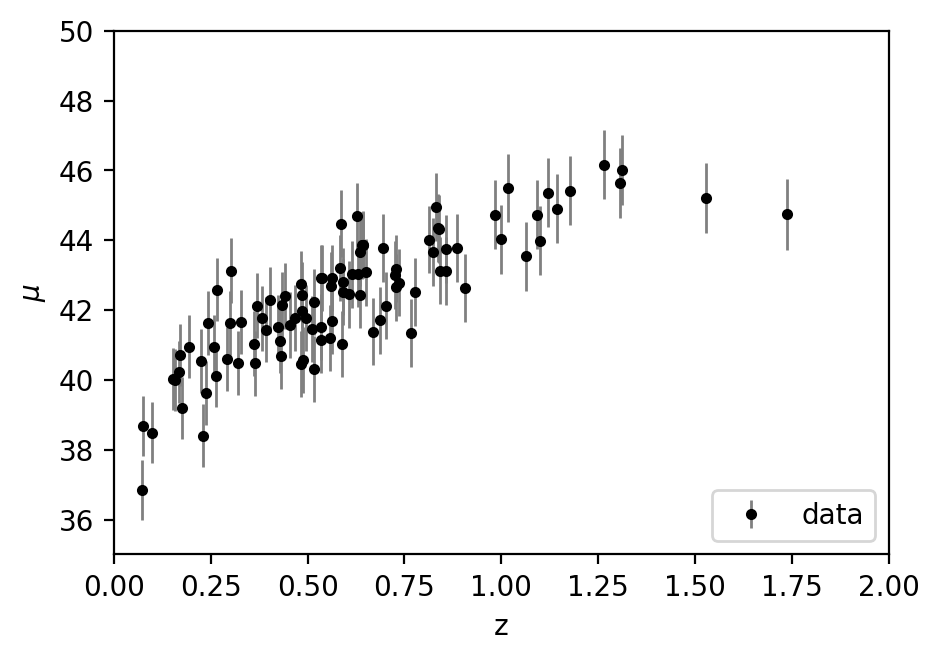

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

fig = plt.figure(figsize=(5, 3.4))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

First let's fit our supernova synthetic data from last time using GPR.

 - The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
 - Check out what's available in the kernels submodule of sklearn.gaussian_process. Hint: radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
 - Plot the expectation value of the fit as well as the resulting $1-\sigma$ and $2-\sigma$ contours. Interpret the results.

Note. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. Do this at home before the exam.

We now have a suite of data-driven predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample. For the case of supernovae, however, we have physical theory which is $\Lambda CDM$.

First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. I got:
 
\begin{equation}
\mu = 5 log \Biggl ( \frac{c/H_0}{10 pc}(1+z) \int_{0} ^{z} \frac{dz'}{\sqrt{\Omega_m(1+z'^3)+\Omega_{\Lambda}}} \Biggr )
\end{equation}

Assuming a flat Universe, we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$. 
It's a very non-linear model.

- Fit it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$? Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m = 1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem).

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with $10$ times more measurements compared to what you have right now, that is: you want to clone your data.

- Think about the pdf of these data in $z$.
- Using both the GPR fit and your latest $\Lambda CDM$ fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given.

First of all, I print the values of the minimum and maximum redshifts to determine the limits on the x-axis.

In [3]:
print('Maximum redshift: ', max(z_sample))
print('Minimum redshift: ', min(z_sample))

Maximum redshift:  1.7374507015735836
Minimum redshift:  0.07346547115306958


I want to fit the supernova data by using GPR, and I use the radial-basis function kernel. The length scale of the kernel is set to $10$ and I allow optimizations of the length scale in the range $[0.01, 100]$. Then, I initialize the Gaussian process regressor $gpr1$, I fit it with the data in the data set and I predict (by using the model $gpr1$) the values of $\mu$ for the array $redshift$.

In [4]:
N = 2000
redshift = np.linspace(0.01, 2, N)

Scale = 1.
k1 = Scale*kernels.RBF(10, (1e-2, 1e2))

# dmu**2 = variance of the noise
gpr1 = GaussianProcessRegressor(kernel=k1, alpha=dmu**2, random_state=5)
gpr1.fit(z_sample[:, None], mu_sample)
# return_std=True: to return also the standard deviations (mu_err1)
mu1, mu_err1 = gpr1.predict(redshift[:, None], return_std=True)  

I plot the data with the error bars and the fit done with GPR with the resulting $1-\sigma$ and $2-\sigma$ contours.

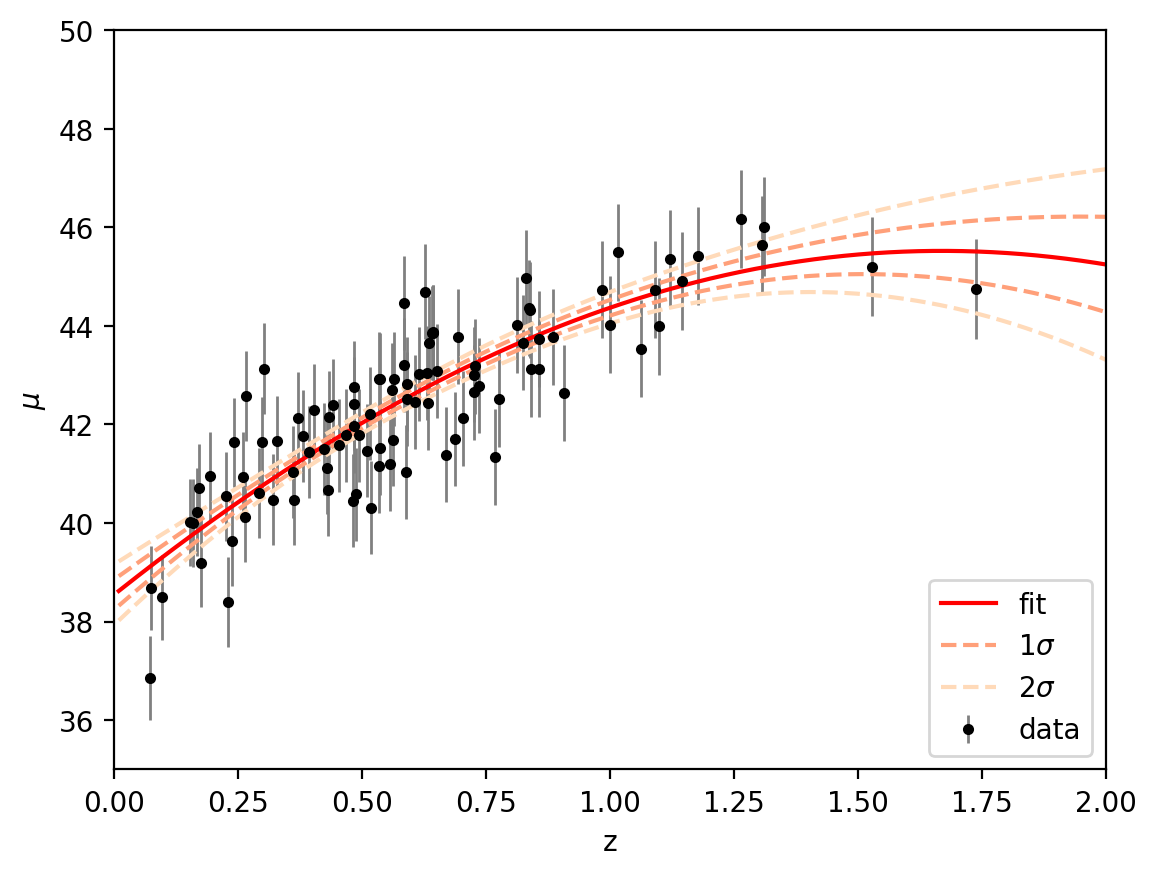

In [5]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(redshift, mu1, color='red', label='fit')
plt.plot(redshift, mu1-mu_err1, color='lightsalmon', ls='--', label=r'$1\sigma$')
plt.plot(redshift, mu1+mu_err1, color='lightsalmon',  ls='--')
plt.plot(redshift, mu1-2*mu_err1, color='peachpuff', ls='--', label=r'$2\sigma$')
plt.plot(redshift, mu1+2*mu_err1, color='peachpuff', ls='--')

plt.legend()
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

To perform a better fit, I choose the kernel with cross-validation. To do that, I initialize an array containing different combinations of kernels, I initialize the Gaussian process regressor ($gprCV$) and I compute the cross-validation analysis with $k=5$.

In [6]:
kernel_options = [kernels.ConstantKernel(1., (1e-2, 1e2))*kernels.RBF(10, (1e-2, 1e2)),
    kernels.ConstantKernel(1., (1e-3, 1e3))*kernels.Matern(10, (1e-2, 1e2), nu=1.),
    kernels.ConstantKernel(1., (1e-3, 1e3))*kernels.RBF(10, (1e-2, 1e2))+kernels.WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-5, 1)),
    kernels.ConstantKernel(1., (1e-3, 1e3))*kernels.Matern(10, (1e-2, 1e2), nu=2.)+kernels.WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-5, 1)),
]

gprCV = GaussianProcessRegressor()
# scoring='neg_mean_squared_error' to minimize the MSE, n_jobs=-1 to accelerate the search
grid_search = GridSearchCV(estimator=gprCV, param_grid={'kernel': kernel_options}, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(z_sample[:, None], mu_sample)

best_kernel = grid_search.best_params_['kernel']

I repeat the same procedure as before, but in this case I use as kernel the best one obtained from cross-validation.

In [7]:
k2 = best_kernel

gpr2 = GaussianProcessRegressor(kernel=k2, alpha=dmu**2, random_state=0)
gpr2.fit(z_sample[:, None], mu_sample)
mu2, mu_err2 = gpr2.predict(redshift[:, None], return_std=True)

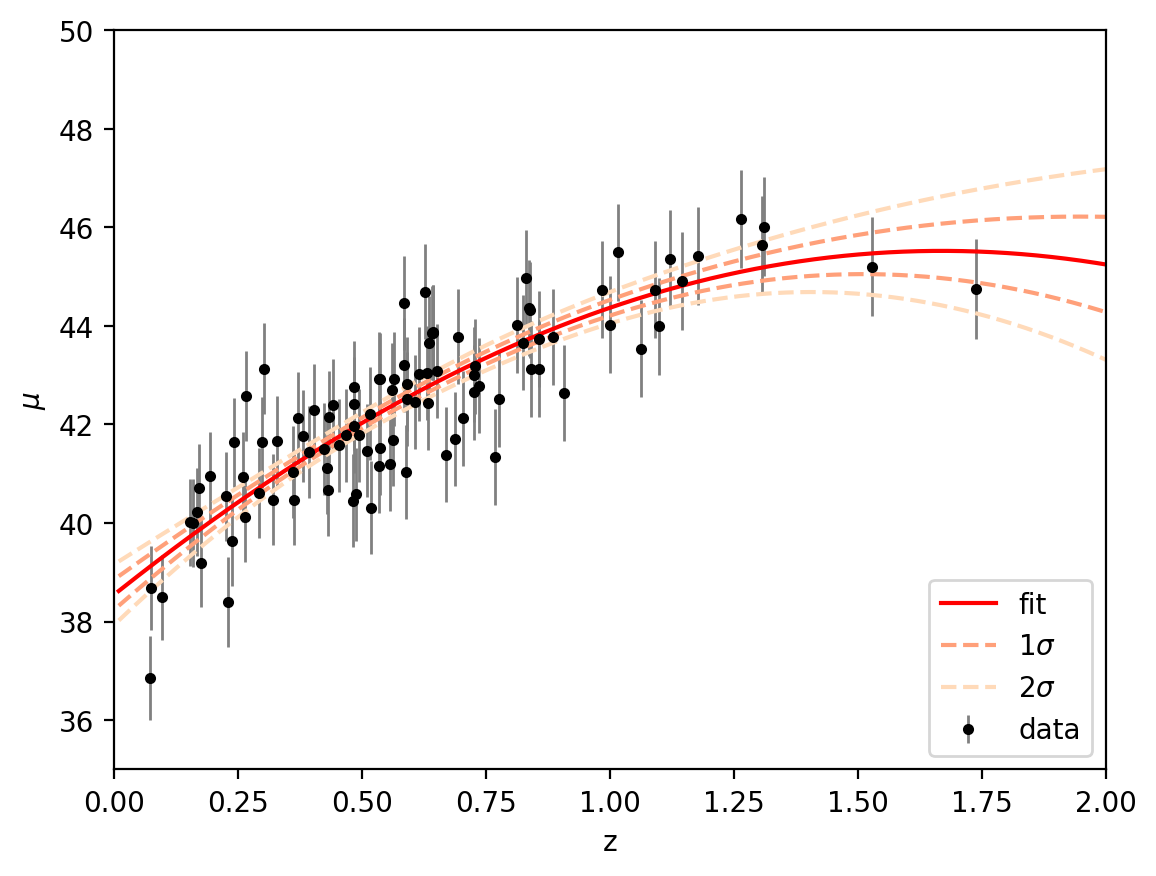

In [8]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(redshift, mu2, color='red', label='fit')
plt.plot(redshift, mu2-mu_err2, color='lightsalmon', ls='--', label=r'$1\sigma$')
plt.plot(redshift, mu2+mu_err2, color='lightsalmon',  ls='--')
plt.plot(redshift, mu2-2*mu_err2, color='peachpuff', ls='--', label=r'$2\sigma$')
plt.plot(redshift, mu2+2*mu_err2, color='peachpuff', ls='--')

plt.legend()
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

##### Fit with $H_0$ and $\Omega_m$

I initialize the model by setting as values: $H_0 = 71$, $\Omega_m = 0.27$ and $\Omega_{de} = (1-0.27)$. After defining a new array of redshifts ($z2$), I compute the corresponding values of $\mu$ ($\mu\_cosmo$) by using the cosmological model previously defined ($cosmo$). Consequently, I plot the result.

In [9]:
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
z2 = np.linspace(0.01, 2, 100)
mu_cosmo = cosmo.distmod(z2)

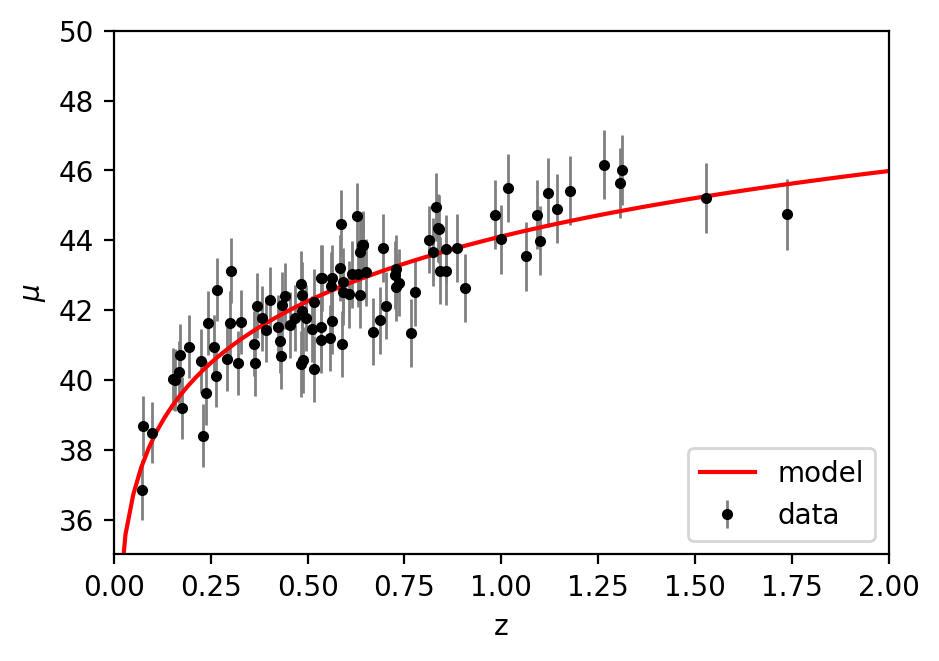

In [10]:
fig = plt.figure(figsize=(5, 3.4))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z2, mu_cosmo, color='red', label='model')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

To compute $H_0$ and $\Omega_m$, I define a function that returns for any cosmological model the values of $\mu$. In fact, starting from the initial guess, I want to find the optimized values of $H_0$ and $\Omega_m$ that better describe the data.

In [11]:
def lambdaCDM(redsh, H0, Om0):
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=1-Om0)
    return cosmo.distmod(redsh).value  # .value because I want the value without the unity

initial_guess = [71, 0.27]
par, cov = curve_fit(lambdaCDM, z_sample, mu_sample, p0=initial_guess)

H0_fit, Om0_fit = par
print('Measured value of H_0: ', H0_fit)
print('Measured value of Omega_m: ', Om0_fit)

Measured value of H_0:  70.37499559846061
Measured value of Omega_m:  0.2771801319509052


Consequently, I initialize a $\Lambda CDM$ model which is described by the optimized $H_0$ and $\Omega_m$ parameters, and I fit the data with such model.

In [12]:
cosmo1 = LambdaCDM(H0=H0_fit, Om0=Om0_fit, Ode0=1-Om0_fit)
mu_cosmo1 = cosmo1.distmod(z2)

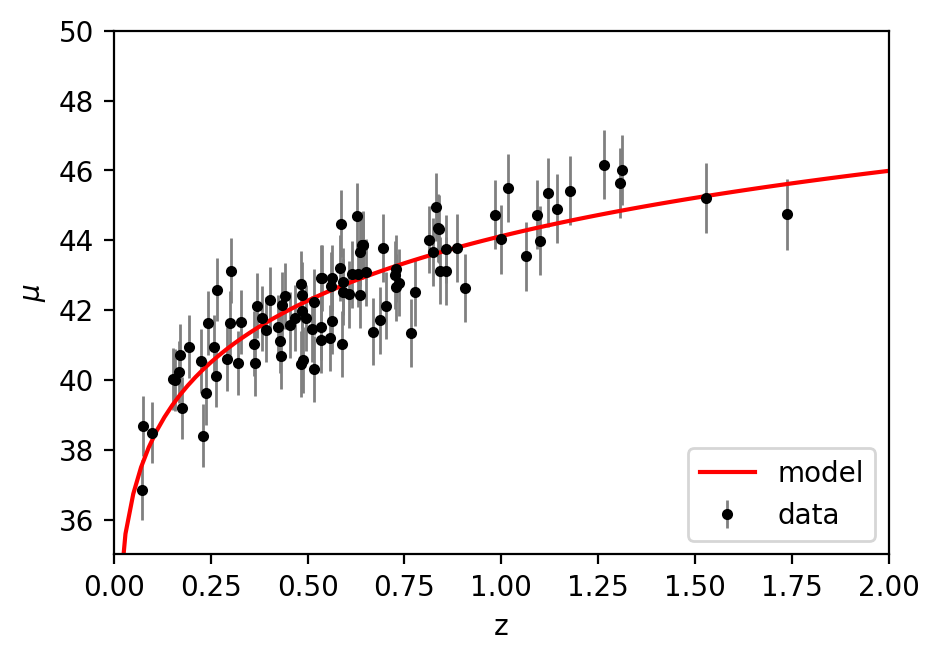

In [13]:
fig = plt.figure(figsize=(5, 3.4))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z2, mu_cosmo1, color='red', label='model')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

To understand wheter the two parameters are correlated or not, I print the covariance matrix obtained from the fit.

In [14]:
print(cov)

[[55.95710524 -1.6753799 ]
 [-1.6753799   0.05961965]]


In [15]:
H0_err = np.sqrt(cov[0][0])
Om_err = np.sqrt(cov[1][1])
H0Om_corr = cov[0][1]/(H0_err*Om_err)  # expression for the correlation: rho = sigma_xy/(sigma_x*sigma_y)

print('H_0 error: ', H0_err)
print('Omega_m error: ', Om_err)
print('Correlation between the two parameters: ', H0Om_corr)

H_0 error:  7.4804481975029775
Omega_m error:  0.24417135057731612
Correlation between the two parameters:  -0.9172568745298547


If the correlation is close to $1$ or $-1$, the two parameters are correlated. In this case the correlation is very close to $-1$: the two parameters are correlated.

I can study the correlation also by using MCMC and by representing the results of the analysis with a corner plot. To do that I need to define the logarithm of the likelihood function in which I select the ranges in which $H_0$ and $\Omega_m$ are not defined.

In [16]:
def logLike(params, z3, mu_sample):
    H0, Om0 = params
    
    if Om0<0 or Om0>1:
        return -np.inf
    
    if H0<50 or H0>85:
        return -np.inf
    
    Cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=1-Om0)
    mu_model = Cosmo.distmod(z3).value
    sigma2 = np.var(mu_sample-mu_model)
    
    return -np.sum((mu_sample-mu_model)*(mu_sample-mu_model)/sigma2)/2

In [17]:
nwalkers = 50
ndim = 2  # number of parameters to estimate (H_0 and Omega_m)
positions = np.array([H0_fit, Om0_fit])+1e-4*np.random.randn(nwalkers, ndim)
nsteps = 1000

sampler = emcee.EnsembleSampler(nwalkers, ndim, logLike, args=(z_sample, mu_sample))
sampler.run_mcmc(positions, nsteps, progress=True)

samples = sampler.get_chain(flat=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.32it/s]


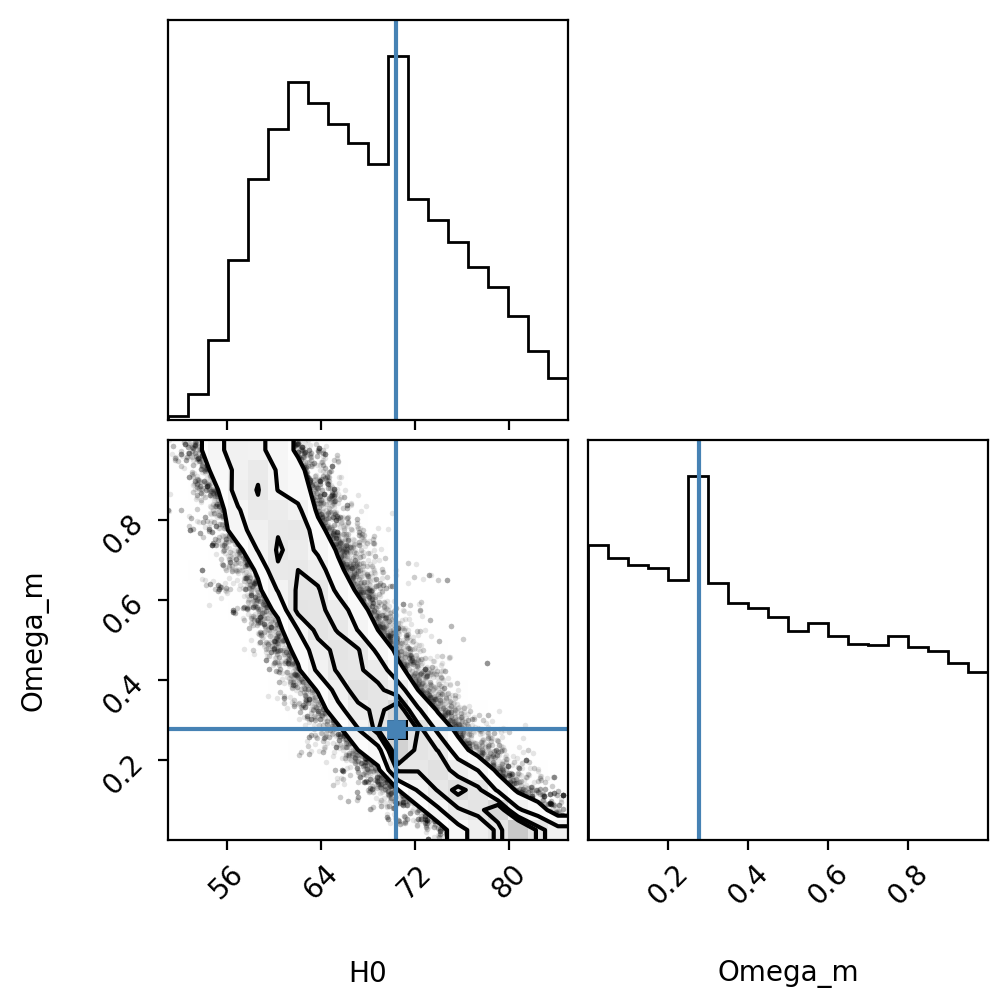

In [18]:
fig = corner.corner(samples, labels=['H0', 'Omega_m'], truths=[H0_fit, Om0_fit])
plt.show()

##### Without dark energy

This time, I define a new cosmological model by setting the value of $\Omega_m$ to $1$ and the one of $\Omega_{de}$ to $0$, and by assuming the value of $H_0$ to be the optimized one. I plot the resulting fit on the top of the data.

In [19]:
cosmo2 = LambdaCDM(H0=H0_fit, Om0=1, Ode0=0)
mu_cosmo2 = cosmo2.distmod(z2)

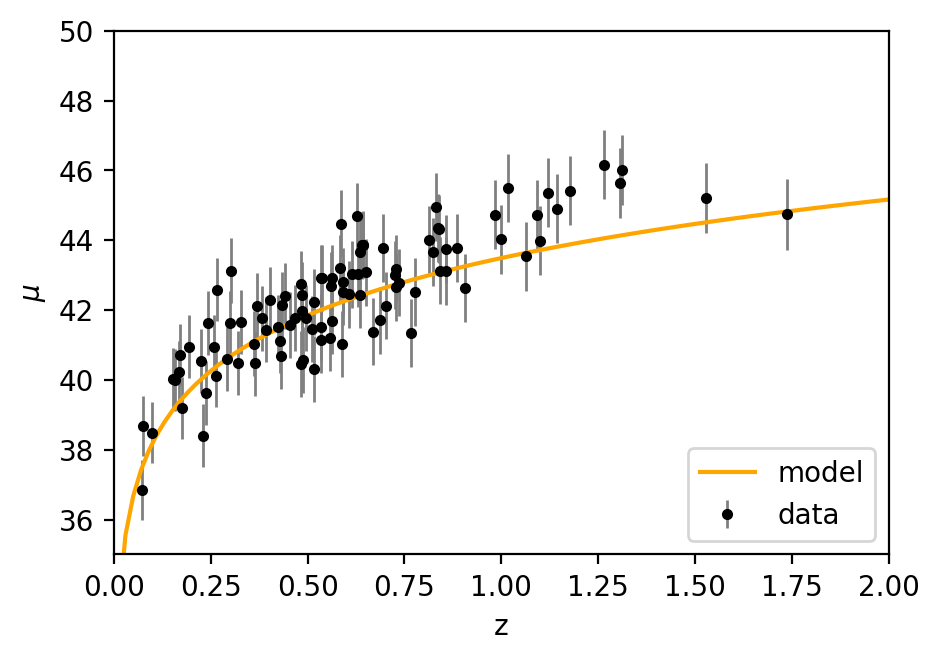

In [20]:
fig = plt.figure(figsize=(5, 3.4))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z2, mu_cosmo2, color='orange', label='model')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

I compare the models with $\Omega_m=0.27$ and $\Omega_m=1$.

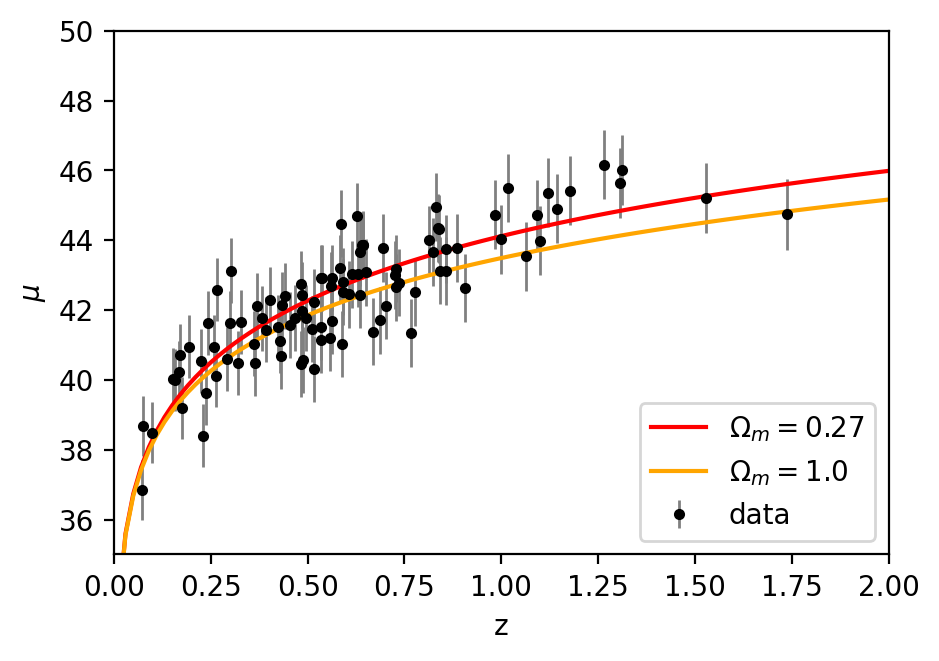

In [21]:
fig = plt.figure(figsize=(5, 3.4))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z2, mu_cosmo1, color='red', label=r'$\Omega_m = 0.27$')
plt.plot(z2, mu_cosmo2, color='orange', label=r'$\Omega_m = 1.0$')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

I compute the Bayesian Information Criterion for both the models and I compare the results.

In [27]:
def logLike2(params, z4, mu_sample):
    H0 = params[0]
    Om0 = 1
    
    if H0<50 or H0>85:
        return -np.inf
    
    Cosmo1 = LambdaCDM(H0=H0, Om0=Om0, Ode0=1-Om0)
    mu_model2 = Cosmo1.distmod(z4).value
    sigma2_2 = np.var(mu_sample-mu_model2)
    
    return -np.sum((mu_sample-mu_model2)*(mu_sample-mu_model2)/sigma2_2)/2

In [28]:
# model with dark energy:
K1 = 2  # H0, Om0
logLike_DE = logLike(np.array([H0_fit, Om0_fit]), z_sample, mu_sample)
BIC_DE = K1*np.log(len(z_sample))-2*logLike_DE

# without dark energy:
K2 = 1  # H0
logLike_noDE = logLike2(np.array([H0_fit, 1]), z_sample, mu_sample)
BIC_noDE = K2*np.log(len(z_sample))-2*logLike_noDE

print(f'BIC with dark energy: {BIC_DE:.2f}')
print(f'BIC without dark energy: {BIC_noDE:.2f}')

BIC with dark energy: 109.21
BIC without dark energy: 127.69


The two models have a BIC value that is not much different from each other, so in principle we can't say that one model is preferred over the other. However, the BIC for the model with dark energy is slightly smaller than the one without dark energy, therefore we can say that, even if the two models' BIC are not decisive, the model that includes dark energy is the preferred one.

##### Clone the data

I start with GPR, and I draw samples from the Gaussian distribution defined by the mean value and the standard deviation found from the Gaussian process regression analysis. I plot the results.

In [29]:
M = 200
Redshift = np.linspace(0.01, 2, M)

mu3, mu_err3 = gpr2.predict(Redshift[:, None], return_std=True)
muGpr = np.random.normal(loc=mu3, scale=mu_err3)

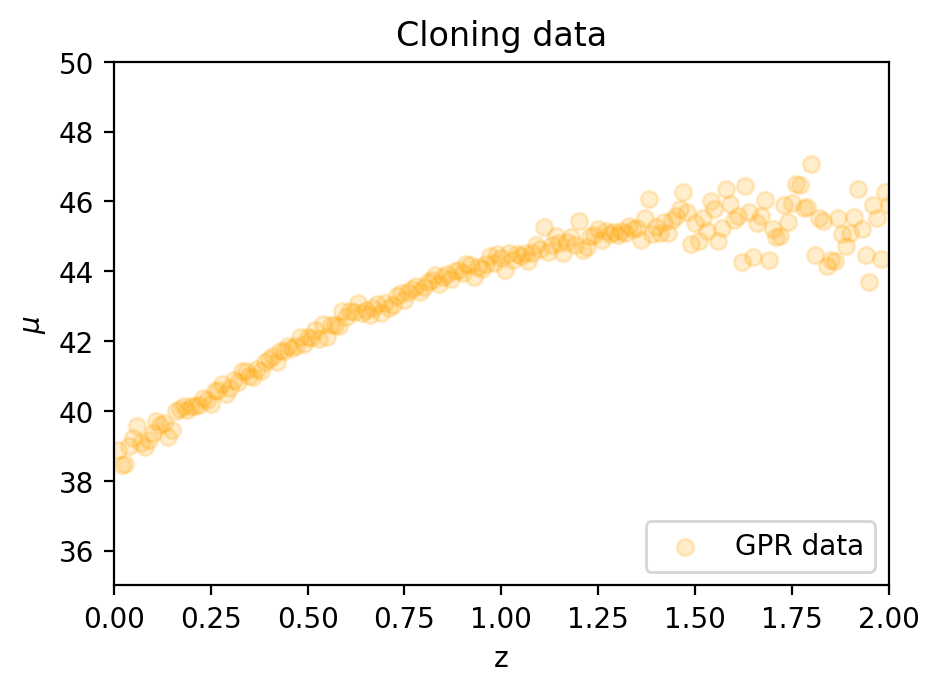

In [30]:
fig = plt.figure(figsize=(5, 3.4))

plt.scatter(Redshift, muGpr, color='orange', label='GPR data', alpha=0.2)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Cloning data')
plt.show()

Let's try with MCMC. I initialize the values of $H_0$ and $\Omega_m$ for MCMC by computing the means of the two distributions of samples obtained from the previous MCMC analysis, and I define a cosmological model based on such values. Consequently, I compute the corresponding values of $\mu$, and I plot the results.

In [31]:
mu_MCMC = []
H0_mcmc, Om0_mcmc = np.mean(samples, axis=0)
COSMO = LambdaCDM(H0=H0_mcmc, Om0=Om0_mcmc, Ode0=1-Om0_mcmc)

for s in Redshift:
    mu_mcmc = COSMO.distmod(Redshift).value
    mu_MCMC.append(mu_mcmc)

mu_MCMC = np.array(mu_MCMC)

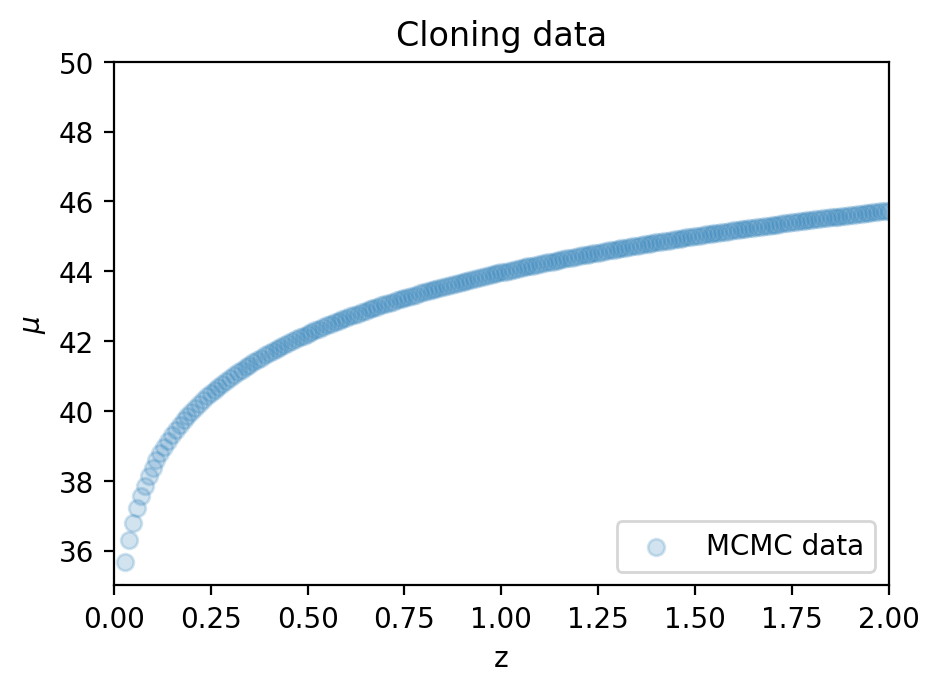

In [32]:
fig = plt.figure(figsize=(5, 3.4))

plt.scatter(Redshift, mu_MCMC[0], label='MCMC data', alpha=0.2)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Cloning data')
plt.show()

I want to compare the two procedures.

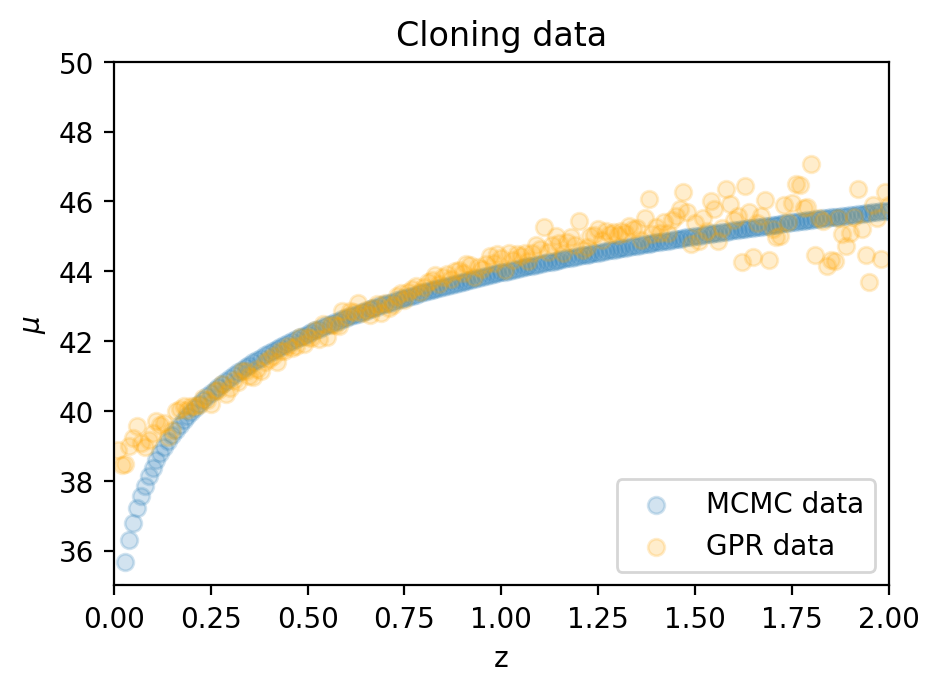

In [33]:
fig = plt.figure(figsize=(5, 3.4))

plt.scatter(Redshift, mu_MCMC[0], label='MCMC data', alpha=0.2)
plt.scatter(Redshift, muGpr, color='orange', label='GPR data', alpha=0.2)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Cloning data')
plt.show()

As I can see, because MCMC is based on a theoretical model, the MCMC data are better distributed to represent the cosmological model from which the data points are drawn. If instead I look at the GPR data, they do not precisely follow the theoretical model because they are not drawn from an analytical model but from a GPR analysis.